# Create the reference solar abundance file

Here we join the Asplund+ (2009) data with other sources of information to create our output `solar_abundances.fits` file.

In [1]:
output_file = 'solarabundances.fits'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table,Column,join

## Read in the Asplund+ (2009) data 
*For convenience, cull to Z < 75.* 

In [123]:
fl = 'asplund2009_abundances.txt'
asplund = Table.read(fl,format='ascii',comment=';')
asplund.remove_column('DIFF_PH_MET')

#Excise Z>75 data
gd = (asplund['Z'] <= 75)
solar = asplund[gd]

Add column for references:

In [124]:
reference_column = Column(['Asplund+ (2009)']*np.size(solar), name='Reference', dtype='U30')
solar.add_column(reference_column)

## Adopt the Steffen+ (2015) oxygen abundance

In [125]:
o_indx = np.where((solar['ELEMENT'] == 'O'))[0][0]
solar[o_indx]

Z,ELEMENT,PHOTO,PHOTO_ERR,METEOR,METEOR_ERR,BEST,ERR,Reference
int64,str2,float64,float64,float64,float64,float64,float64,str30
8,O,8.69,0.05,8.4,0.04,8.69,0.05,Asplund+ (2009)


In [126]:
steffen = [8.76, 0.02]

solar['BEST'][o_indx] = steffen[0] # Steffen abundance
solar['ERR'][o_indx] = steffen[1]

solar['PHOTO'][o_indx] = steffen[0] # Steffen abundance
solar['PHOTO_ERR'][o_indx] = steffen[1]

solar['Reference'][o_indx] = 'Steffen+ (2015)'

#Total mass:
mmm = (10.**(solar['PHOTO'][0]-12.)/0.7381)
#Old oxygen mass:
print("Old O mass fraction: {0:0.5f}".format(10.**(asplund['PHOTO'][o_indx]-12.)*16./mmm))
#New oxygen mass:
print("New O mass fraction: {0:0.5f}".format(10.**(solar['BEST'][o_indx]-12.)*16./mmm))

Old O mass fraction: 0.00578
New O mass fraction: 0.00680


In [127]:
solar[o_indx]

Z,ELEMENT,PHOTO,PHOTO_ERR,METEOR,METEOR_ERR,BEST,ERR,Reference
int64,str2,float64,float64,float64,float64,float64,float64,str30
8,O,8.76,0.02,8.4,0.04,8.76,0.02,Steffen+ (2015)


## Add mean atomic mass

In [128]:
iso = Table.read('isotopes.dat',format='ascii',comment=';;')
iso.keep_columns(['Z','AtomicWeight'])
atoms = join(solar,iso,keys='Z')

Now we have all the information we want in the combined table `atoms`.

In [129]:
atoms[0:5]

Z,ELEMENT,PHOTO,PHOTO_ERR,METEOR,METEOR_ERR,BEST,ERR,Reference,AtomicWeight
int64,str2,float64,float64,float64,float64,float64,float64,str30,float64
1,H,12.0,30.0,8.22,0.04,12.0,0.0,Asplund+ (2009),1.0079
2,He,10.93,0.01,1.29,30.0,10.93,0.01,Asplund+ (2009),4.002602
3,Li,1.05,0.1,3.26,0.05,3.26,0.05,Asplund+ (2009),6.968
4,Be,1.38,0.09,1.3,0.03,1.31,0.03,Asplund+ (2009),9.01218
5,B,2.7,0.2,2.79,0.04,2.79,0.04,Asplund+ (2009),10.813


## Write to output file

In [130]:
atoms.write(output_file,overwrite=True)

## Mean metal abundances by mass

In [139]:
# The abundance by mass:
eps = (10.**(atoms['BEST']-12.)*atoms['AtomicWeight']).data
total_mass = eps.sum()

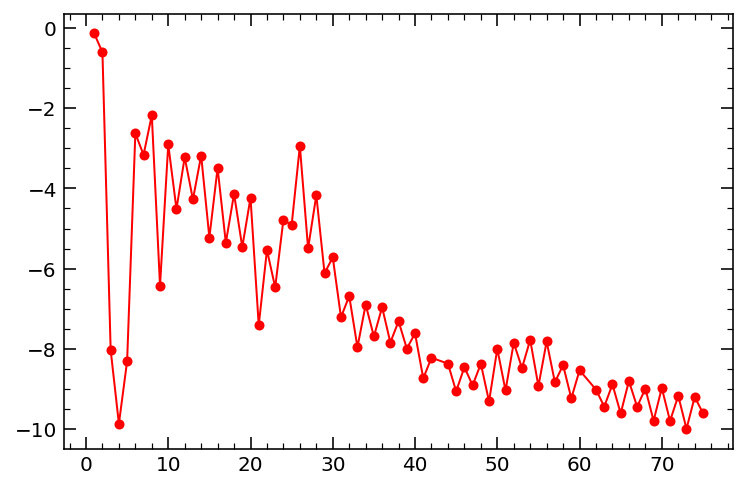

In [140]:
plt.plot(atoms['Z'],np.log10(eps/total_mass),'ro-',markersize=4,lw=1);

## Calculate X, Y, Z

In [141]:
X = eps[0]/total_mass
Y = eps[1]/total_mass

In [142]:
zzz = (atoms['Z'] > 2)
Z = eps[zzz].sum()/total_mass

In [143]:
print("\nMean abundances by mass: X=H, Y=He, Z=metals; mean mass per H atom, µ.\n")
print("\tX = {0:0.4f}".format(X))
print("\tY = {0:0.4f}".format(Y))
print("\tZ = {0:0.4f}".format(Z))
print("\tµ = {0:0.4f}".format(1./X))


Mean abundances by mass: X=H, Y=He, Z=metals; mean mass per H atom, µ.

	X = 0.7368
	Y = 0.2491
	Z = 0.0141
	µ = 1.3572


```
``` Thus the metal mass fraction in the solar system is **Z = 0.0141**.

The mean mass per H is **µ = 1.36.**

```

```
## Copy solarabundances.fits to `pyND` directory.

In [147]:
!cp solarabundances.fits ~/python/pyND/analysis/data/